# Visualize DLC results 

In [1]:
from ipyfilechooser import FileChooser
import os

try:
    %store -r filename
    filename = os.path.dirname(filename)
except NameError:
    filename = "//10.69.168.1/crnldata/forgetting/Aurelie/CheeseboardExperiment/DAQ_data/AB/"

fc1 = FileChooser(filename, select_default=True, show_only_dirs=False, title="<b>Choose .h5 file</b>")
display(fc1)

def update_file(chooser):
    global filename
    if chooser.selected:
        filename = chooser.selected
        %store filename

fc1.register_callback(update_file)

FileChooser(path='\\10.69.168.1\crnldata\forgetting\Aurelie\CheeseboardExperiment\DAQ_data\AB', filename='', t…

Stored 'filename' (str)


Acquisition with DAQ, frame rate = 4 fps
Total trial duration: 71 sec
Latency to reward: 4 sec
Time spent in reward zone: 38 sec (54 %)
Crossings in the reward zone: 1
Total distance run: 225 cm
Distance run to reward: 28 cm
Crossings per meter: 3.57
Average speed: 7.45 cm/s


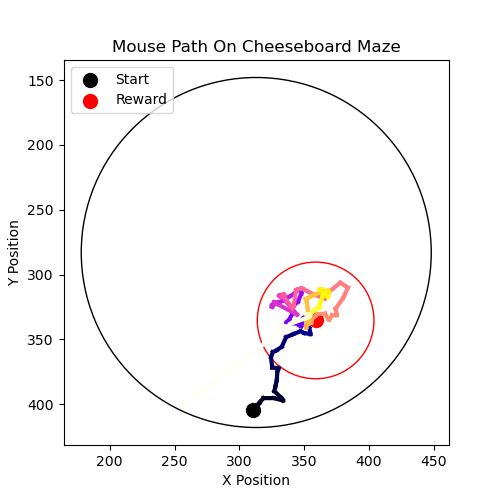

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
from pathlib import Path
import re
%matplotlib widget

# Load HDF5 file
df = pd.read_hdf(filename)
directory = os.path.dirname(filename)
timestamps_path = Path(directory,'timeStamps.csv')
if timestamps_path.exists():
    timestamps = pd.read_csv(timestamps_path)
    frame_rate = round(1/(np.mean(np.diff(timestamps.iloc[:,1]))/1000))  # fps
    print(f'Acquisition with DAQ, frame rate = {frame_rate} fps')
else:
    frame_rate = 16  # fps /!\ CHANGE ACCORDING TO YOUR DATA
    print(f'Acquisition with Webcam, frame rate = {frame_rate} fps')
with open("//10.69.168.1/crnldata/forgetting/Aurelie/CheeseboardExperiment/DAQ_data/AB/Reward_position.txt", "r") as file:
    text = file.read()  
numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)
reward_x, reward_y = map(float, numbers)

# Define parameters
pixel_to_cm = 2.25  
reward_zone = 20 * pixel_to_cm if "Training" in filename else 20 * pixel_to_cm  # 8 cm for training, 20 cm for test
table_center_x, table_center_y = 313, 283  # Center of the cheeseboard table on the video
table_radius = 270 / 2
min_stay_at_reward = 5 * frame_rate  # 5 seconds

# Define functions
def calculate_relative_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_distance_run(x_coords, y_coords):
    distances = np.sqrt(np.diff(x_coords) ** 2 + np.diff(y_coords) ** 2)
    for i in range(1, len(distances) - 1):
        if np.isnan(distances[i]):
            neighbors = [distances[i-1], distances[i+1]]
            distances[i] = np.mean([x for x in neighbors if not np.isnan(x)])
    total_distance_cm = np.nansum(distances) / pixel_to_cm  # Convert to cm
    return total_distance_cm, distances

def remove_abnormal_speed(x, y, max_speed):
    distances = np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2)  
    for i in range(1, len(distances) - 1):
        if np.isnan(distances[i]):
            neighbors = [distances[i-1], distances[i+1]]
            distances[i] = np.mean([x for x in neighbors if not np.isnan(x)])
    mask = np.insert(distances <= max_speed, 0, True)  # Keep first point
    return x[mask], y[mask]

# Remove uncertain location predictions (likelihood < 0.9)
df.iloc[:, 0] = df.apply(lambda row: row.iloc[0] if row.iloc[-1] > 0.9 else np.nan, axis=1)
df.iloc[:, 1] = df.apply(lambda row: row.iloc[1] if row.iloc[-1] > 0.9 else np.nan, axis=1)

X = df.iloc[:, 0]
Y = df.iloc[:, 1]

# Separate the individual's positions into x and y coordinates
individual_x = np.array(X.values)
individual_y = np.array(Y.values)

# Define when the mouse is on the cheeseboard (start)
for i, x in enumerate(individual_x):
    y = individual_y[i]
    if calculate_relative_distance(x, y, table_center_x, table_center_y) >= table_radius:
        individual_x[i] = np.nan
        individual_y[i] = np.nan

x_start = individual_x[~np.isnan(individual_x)][0] if np.any(~np.isnan(individual_x)) else None # first non nan value
y_start = individual_y[~np.isnan(individual_y)][0] if np.any(~np.isnan(individual_y)) else None # first non nan value

start_frame = np.where(individual_x == x_start)[0].item()
for i in range(len(individual_x)-1, 0, -1): # Find the last non-NaN value which is not isolated
    if not np.isnan(individual_x[i]) and not np.isnan(individual_x[i-1]):
        last_frame = i
        break
    
if timestamps_path.exists():
    start_time = timestamps.iloc[start_frame,1].item() / 1000
    end_time = timestamps.iloc[-1,1].item() / 1000
    duration_trial = end_time - start_time
else:
    duration_trial = (last_frame - start_frame) / frame_rate
print(f'Total trial duration: {round(duration_trial)} sec')

# Define when the mouse eats the reward (end)
found_reward_frame = np.nan
consecutive_count = 0
for i, (x, y) in enumerate(zip(individual_x, individual_y)):
    if calculate_relative_distance(x, y, reward_x, reward_y) <= reward_zone:
        consecutive_count += 1
    else:
        consecutive_count = 0  
    if consecutive_count > min_stay_at_reward:
        found_reward_frame = (i - min_stay_at_reward)
        break
    
if timestamps_path.exists():
    found_reward_time = timestamps.iloc[found_reward_frame,1].item() / 1000
    latency = (found_reward_time - start_time)
else:
    latency = (found_reward_frame - start_frame) / frame_rate
print(f'Latency to reward: {round(latency)} sec')

# Define the time spent inside the reward zone
time_spent_in_zone = 0

for i, (x, y) in enumerate(zip(individual_x, individual_y)):
    if calculate_relative_distance(x, y, reward_x, reward_y) <= reward_zone:
        time_spent_in_zone += 1

time_spent_in_zone = time_spent_in_zone / frame_rate
print(f'Time spent in reward zone: {round(time_spent_in_zone)} sec ({round(time_spent_in_zone / duration_trial * 100)} %)')

# Remove NaN values 
individual_x_filt = individual_x[~np.isnan(individual_x)]        
individual_y_filt = individual_y[~np.isnan(individual_y)]

# Define the number of times the mouse enters the reward zone
enter_reward_zone = 0
consecutive_count = 0
for i, (x, y) in enumerate(zip(individual_x_filt, individual_y_filt)):
    if calculate_relative_distance(x, y, reward_x, reward_y) <= reward_zone:
        if consecutive_count == 0:
            enter_reward_zone += 1
            consecutive_count = 1
    else:
        consecutive_count = 0   

print(f'Crossings in the reward zone: {enter_reward_zone}')

total_distance, distances = calculate_distance_run(individual_x[start_frame:last_frame], individual_y[start_frame:last_frame])
print(f"Total distance run: {round(total_distance)} cm")

distance_to_reward, distances_to_reward = calculate_distance_run(individual_x[start_frame:found_reward_frame], individual_y[start_frame:found_reward_frame])
print(f'Distance run to reward: {round(distance_to_reward)} cm')

print(f"Crossings per meter: {round(enter_reward_zone / (round(distance_to_reward) / 100), 2)}")

print(f"Average speed: {round(np.nanmean(distances_to_reward)/pixel_to_cm*frame_rate,2)} cm/s")

# Create the plot
fig, ax = plt.subplots(figsize=(5, 5)) 

# Plot individual positions over time
cmap = plt.get_cmap('gnuplot2')
norm = plt.Normalize(vmin=0, vmax=len(individual_x_filt))

for i in range(1, len(individual_x_filt)):
    ax.plot(individual_x_filt[i-1:i+1], individual_y_filt[i-1:i+1], color=cmap(norm(i)), linewidth=3)
#plt.plot(individual_x_filt, individual_y_filt, label="Individual's Path", color='b')

plt.scatter(x_start, y_start, color='black', s=100, label='Start')
plt.scatter(reward_x, reward_y, color='red', s=100, label='Reward')

# Draw reward zone circle
reward_circle = plt.Circle((reward_x, reward_y), reward_zone, color='r', fill=False)
plt.gca().add_patch(reward_circle)  

# Draw cheeseboard circle
table_circle = plt.Circle((table_center_x, table_center_y), table_radius, color='k', fill=False)
plt.gca().add_patch(table_circle) 

# Add labels and title
ax.set_aspect('equal')
ax.invert_yaxis()
plt.title(f'Mouse Path On Cheeseboard Maze')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend(loc='upper left')
plt.show()